In [ ]:
#get the dataset
!gdown https://drive.google.com/u/0/uc?id=1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri&export=download
#and unzip the downloaded file
!unzip dataset.zip

In [3]:
# Imports 

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import os
import glob
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
from torch.optim import SGD, Adam
from tqdm import tqdm

print(torch.__version__)

1.6.0+cu101


In [4]:
# Creating the Dataset class from Pytorch to load to the Dataloader

class CatKingdom(Dataset):
    def __init__(self, images, transform):
        self.images_path = images
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, item):
        images = Image.open(self.images_path[item]).convert("RGB")
        transforms = self.transform(images)

        return transforms


In [5]:
# Hyper parameters and configs

root_images_path = "dataset/*"
num_epochs = 20
image_size = 256
batch_size = 32
lr = 0.01
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

images = glob.glob(root_images_path)
train_images, test_images = train_test_split(images, test_size = 0.1, random_state=42)

transformation = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std=std )
])

In [6]:
# Defining the Training and testing dataset and dataloaders

train_dataset = CatKingdom(train_images, transform=transformation)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = CatKingdom(test_images, transform=transformation)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [7]:
# Helper Function

def imshow(dataloader):
  fig = plt.figure(figsize=(24, 16))
  fig.tight_layout()
  images = next(iter(dataloader))

  for num, sample in enumerate(images[:10]):
      # classes = [sample[x] for x in classes]
      plt.subplot(4,6,num+1)
      plt.axis('off')
      sample = sample.cpu().numpy()
      out = np.transpose(sample, (1,2,0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * out + mean
      inp = np.clip(inp, 0, 1)
      plt.imshow(inp)

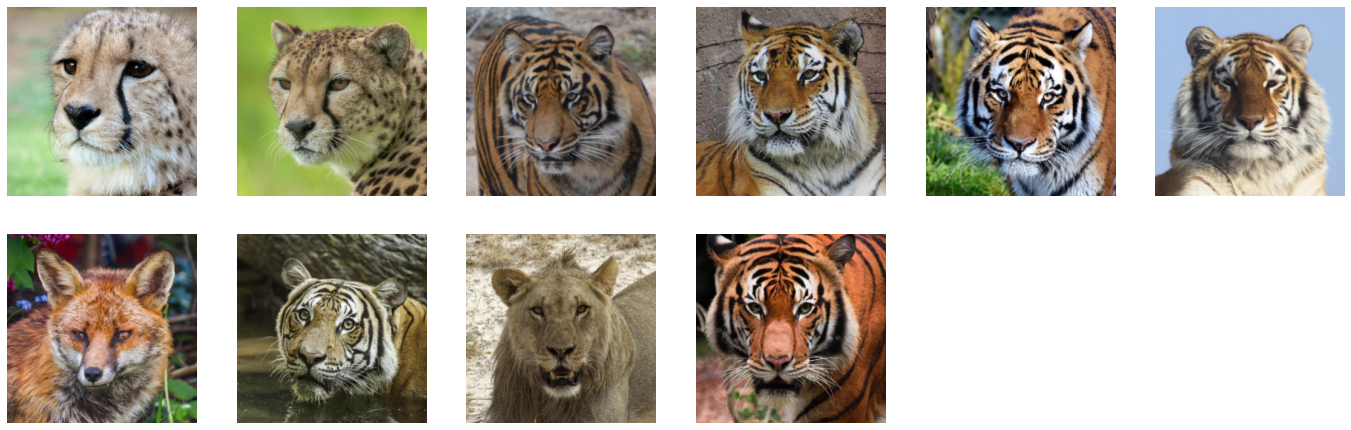

In [8]:
#training dataset loader

imshow(train_dataloader)

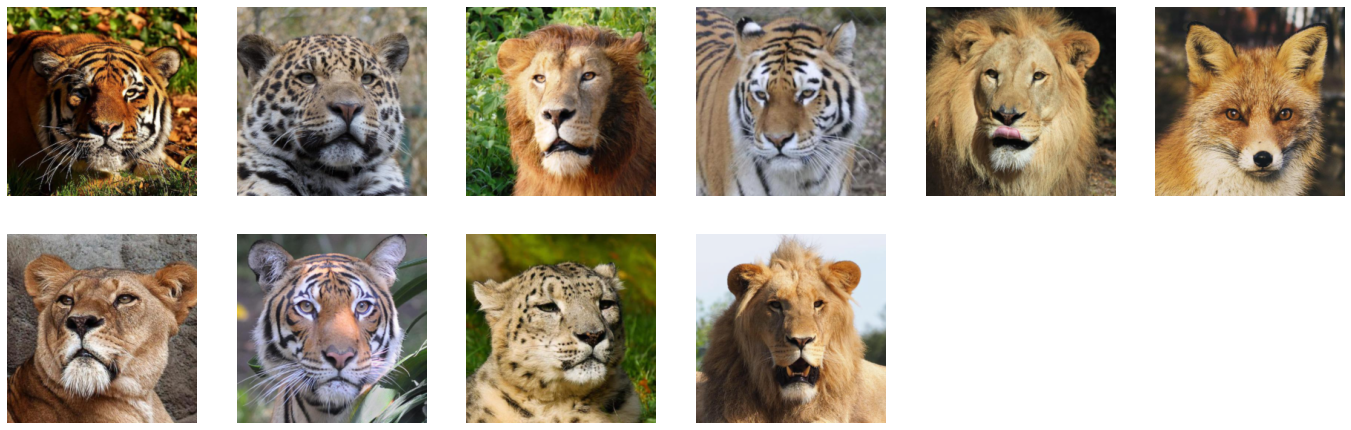

In [9]:
#test dataset loader

imshow(test_dataloader)

In [10]:
# Types of VGG

VGG_type = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512],
    "VGG16": [64,64,"M",128,128,"M",256,256,256,"M",512,512,512,"M",512,512,512,],
    "VGG19": [64,64,"M",28,128,"M",256,256,256,256,"M",512,512,512,512,"M",512,512,512,512]
}

In [11]:
# Defining the Model Architecture


# class ConvAutoEncoder(nn.Module):
#     def __init__(self, channels=3):
#         super(ConvAutoEncoder, self).__init__()
#         self.enc = VGGEncoder("VGG16")
#         self.dec = Decoder(channels)

#     def forward(self, x):
#         x = self.enc(x)
#         x = self.dec(x)

#         return x


class Decoder(nn.Module):
    def __init__(self, out_channels=3):
        super(Decoder, self).__init__()
        self.upconv1 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2,
            padding=0,
        )
        self.upconv2 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2,
            padding=0,
        )
        self.upconv3 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0
        )
        self.upconv4 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=3,
            kernel_size=2,
            stride=2,
            padding=0,
        )

        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu = nn.LeakyReLU(0.2)
        self.op = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.upconv1(x))
        x = self.bn1(x)
        x = self.relu(self.upconv2(x))
        x = self.bn2(x)
        x = self.relu(self.upconv3(x))
        x = self.bn3(x)
        x = self.relu(self.upconv4(x))
        output = self.op(x)

        return x


class VGGEncoder(nn.Module):
    def __init__(self, vgg_version="VGG16", in_channels=3):
        super(VGGEncoder, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv(VGG_type[vgg_version])
        # after completing all the conv layer the final matrix will be [ bs , 512, 7 , 7]

    def forward(self, x):
        x = self.conv_layers(x)

        return x

    def create_conv(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers += [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=3,
                        stride=1,
                        padding=1,
                    ),
                    nn.BatchNorm2d(x),
                    nn.ReLU(),
                ]
                in_channels = x

            elif x == "M":
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]


        return nn.Sequential(*layers)

In [14]:
# Initializing the decoder and the encoder with initializing to CUDA

encoder = VGGEncoder()
decoder = Decoder()

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device ="cuda"

if train_on_gpu:
    encoder.cuda()
    decoder.cuda()

CUDA is available!  Training on GPU ...


In [15]:
# defining the loss and the optimizer

criterion = nn.MSELoss()
autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = Adam(autoencoder_params, lr=lr)

In [16]:
# Training Function

def train(dataloader, bs, epochs ,criterion , optimizer, encoder, decoder):
    n_epochs = epochs
    
    for epoch in range(1, n_epochs+1):
         # keep track of training and validation loss
        train_loss = 0.0
         ###################
        # train the model #
        ###################
        # model by default is set to train
        # model.train()
    
        for batch_i, data in tqdm(enumerate(dataloader), total = len(dataloader)):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                images = data.cuda()
            # clear the gradients of all optimized variables            
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            encoder_op = encoder(images)
            decoder_op = decoder(encoder_op)
            # calculate the batch loss
            loss = criterion(decoder_op, images)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*images.size(0)
            
        
        training_loss = train_loss/len(dataloader.sampler)
        print(' Epoch %d, loss: %.16f' % (epoch, training_loss))

    torch.save(encoder.state_dict(), "encoder.pt")
    torch.save(decoder.state_dict(), "decoder.pt")
                

    return train_loss 
    


In [17]:
# Prediction Function

def predict(encoder, decoder, test_dataloader, device):
    encoder.eval() # eval mode
    decoder.eval() # eval mode
    dataiter = iter(test_dataloader)
    images = dataiter.next()
    images = images.to(device) #since model is in cuda, we need to load images to cuda
    output = encoder(images)
    output = decoder(output)

    # prep images for display
    images = images.cpu().numpy() # bring back again from cuda to cpu to plot

    # use detach when it's an output that requires_grad
    output = output.cpu() # need to load from cuda to cpu
    output = output.detach().numpy() # and then detach it

    n = 10
    plt.figure(figsize=(20,4))

    for i in range(n):
        # originals
        ax = plt.subplot(2, n, i + 1)
        ax.axis('off')
        ax.set_title("Original")
        out = np.transpose(images[i], (1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * out + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        
        # outputs
        ax = plt.subplot(2, n, i + 1 + n)
        ax.axis('off')
        ax.set_title("outputs")
        out = np.transpose(output[i], (1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * out + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        

In [18]:
loss = train(train_dataloader, batch_size, num_epochs ,criterion , optimizer, encoder, decoder)

100%|██████████| 134/134 [01:29<00:00,  1.49it/s]

 Epoch 1, loss: 0.4676199869076262



100%|██████████| 134/134 [01:35<00:00,  1.40it/s]

 Epoch 2, loss: 0.2642790757357291



100%|██████████| 134/134 [01:35<00:00,  1.40it/s]

 Epoch 3, loss: 0.2085098967543239



100%|██████████| 134/134 [01:35<00:00,  1.40it/s]

 Epoch 4, loss: 0.1655280868510592



100%|██████████| 134/134 [01:35<00:00,  1.40it/s]

 Epoch 5, loss: 0.1507405470113146



100%|██████████| 134/134 [01:35<00:00,  1.40it/s]

 Epoch 6, loss: 0.1351982631893587



100%|██████████| 134/134 [01:35<00:00,  1.40it/s]

 Epoch 7, loss: 0.1232245494567878



100%|██████████| 134/134 [01:35<00:00,  1.40it/s]

 Epoch 8, loss: 0.1099961723216703



100%|██████████| 134/134 [01:36<00:00,  1.39it/s]

 Epoch 9, loss: 0.1040103307193037



100%|██████████| 134/134 [01:36<00:00,  1.39it/s]

 Epoch 10, loss: 0.0995020121475769



100%|██████████| 134/134 [01:35<00:00,  1.40it/s]

 Epoch 11, loss: 0.0940425549590118



100%|██████████| 134/134 [01:36<00:00,  1.39it/s]

 Epoch 12, loss: 0.0896623056892159



100%|██████████| 134/134 [01:36<00:00,  1.39it/s]

 Epoch 13, loss: 0.0878212272869266



100%|██████████| 134/134 [01:36<00:00,  1.39it/s]

 Epoch 14, loss: 0.0826679506176632



100%|██████████| 134/134 [01:36<00:00,  1.39it/s]

 Epoch 15, loss: 0.0788925729733918



100%|██████████| 134/134 [01:36<00:00,  1.40it/s]

 Epoch 16, loss: 0.0752494707843376



100%|██████████| 134/134 [01:36<00:00,  1.39it/s]

 Epoch 17, loss: 0.0726986364312959



100%|██████████| 134/134 [01:36<00:00,  1.39it/s]

 Epoch 18, loss: 0.0688296306675639



100%|██████████| 134/134 [01:36<00:00,  1.39it/s]

 Epoch 19, loss: 0.0724883832275085



100%|██████████| 134/134 [01:36<00:00,  1.39it/s]

 Epoch 20, loss: 0.0690699464049169


In [19]:
#loading pretrained models

encoder.load_state_dict(torch.load("encoder.pt", map_location=device))
encoder.eval()
encoder.to(device)

decoder.load_state_dict(torch.load("decoder.pt", map_location=device))
decoder.eval()
decoder.to(device)

Decoder(
  (upconv1): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
  (upconv2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (upconv3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (upconv4): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(2, 2))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (op): Sigmoid()
)

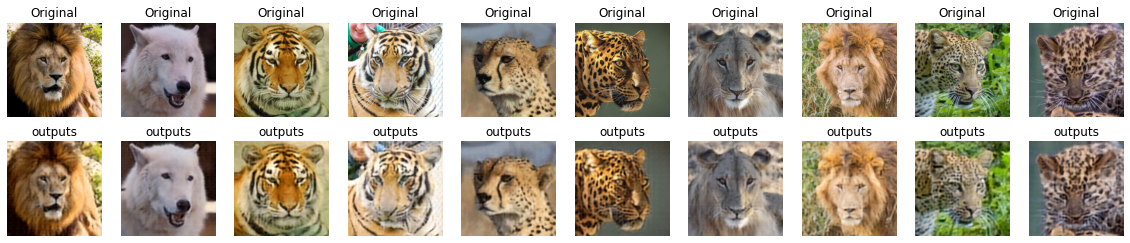

In [20]:
# Prediciton in the test dataset

predict(encoder, decoder, test_dataloader, device)

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


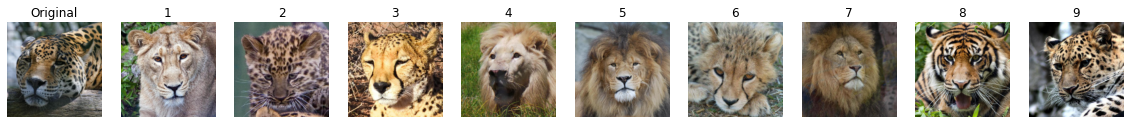

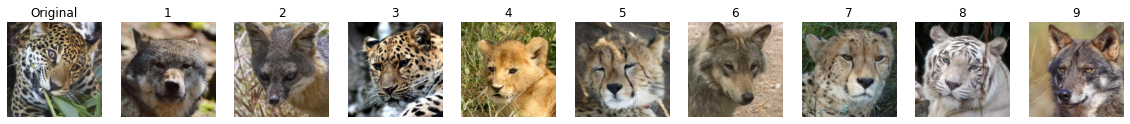

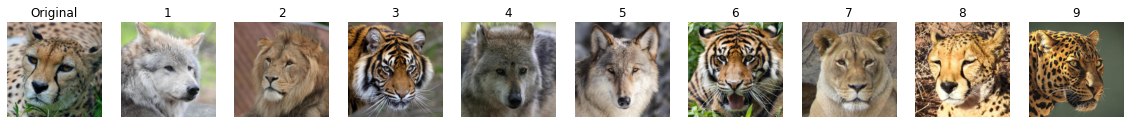

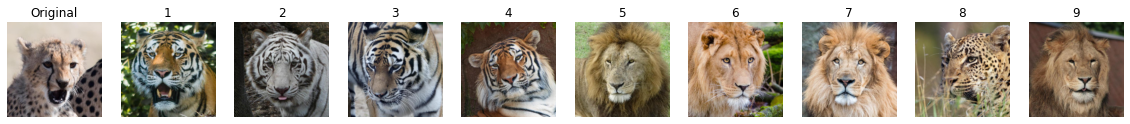

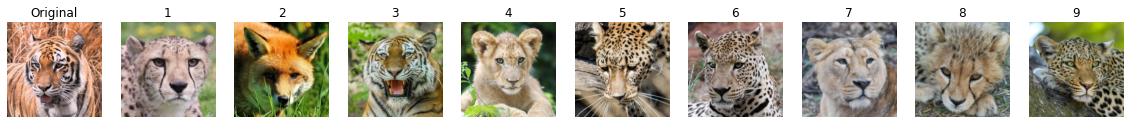

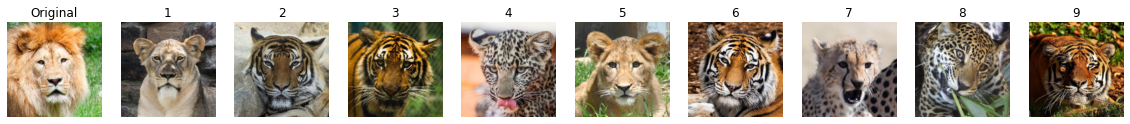

In [28]:
from scipy.spatial.distance import cosine

n = 10

# Function to find similar images to the one supplied by idx
def find_similar_images(idx, model, test_dataloader, device):
    model.eval()
    dataiter = iter(test_dataloader)
    images = dataiter.next()
    images = images.to(device) #since model is in cuda, we need to load images to cuda
    

    # this code block takes one predicted output and compares with the other images to find similarity
    output_idx = model(images[idx].unsqueeze(0)) # output of the index passed
    output_idx = output_idx.cpu() # need to load from cuda to cpu
    output_idx = output_idx.detach().numpy() # and then detach it
    output_idx = output_idx.reshape(output_idx.shape[0], -1)
    

    # takes all the predicted outputs of the images
    output = model(images) # total output of images

    images_original = images.cpu().numpy() # preserving the original images before reshaping to 1D
    images = images.cpu().numpy() # bring back again from cuda to cpu to plot

    # Converting to 1D for finding cosine distance

    output = output.cpu() # need to load from cuda to cpu
    output = output.detach().numpy() # use detach when it's an output that requires_gradand 
    
    # convert images and outputs to 1D vector
    output = output.reshape(output.shape[0], -1)
    images = images.reshape(images.shape[0], -1)


    # calculate the cosine similarity from our reference image to all the other image codes
    similarities = [ (cosine(output_idx[0], output[i][0]), i) for i in range(len(output)) ]
    similarities.sort()
    similar_idxs = [ i for _,i in similarities ]

    # plot top 10 matches
    plt.figure(figsize=(20,10))
    for i, idx in enumerate(similar_idxs[:n]):
        ax = plt.subplot(2, n, i + 1)
        ax.axis('off')
        if i == 0:
          ax.set_title("Original")
        else:
          ax.set_title(i)

        out = np.transpose(images_original[i], (1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * out + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)


for i in [4, 8, 12, 15, 20, 25]: # random images in the batch
  find_similar_images(i, encoder, test_dataloader, device)